In [ ]:
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

In [1]:
import os
import csv
import random

import mne
import time
import utils as u
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.io import ChData
from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)

import pickle

#from pycrostates.datasets import lemon

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


C:\Users\enriq\anaconda1\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
import pycrostates
print(pycrostates.__version__)

0.5.0


In [6]:
t = time.time()
raw = mne.io.read_raw_brainvision('E:\DATA_FOLDER\sub-010002\RSEEG\sub-010002.vhdr', eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)
events, event_dict = mne.events_from_annotations(raw)

Extracting parameters from E:\DATA_FOLDER\sub-010002\RSEEG\sub-010002.vhdr...
Setting channel info structure...
Reading 0 ... 2554999  =      0.000 ...  1022.000 secs...
Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']


In [7]:
# Cleaning EEG
cleaned_eeg = u.preprocessing(raw)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using EOG channel: VEOG
EOG channel index for this subject is: [16]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel VEOG for blink detection
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 20.25 Hz)
- Filter length: 25000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 62 significant peaks
Number of EOG events detected: 62


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 62 events and 2501 original time points ...
0 bad epochs dropped
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 27.9s.
Using EOG channel: VEOG
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [8]:
# Dictionary with data
d = u.dictionary(cleaned_eeg)

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']


In [9]:
# Samples
start_samples_ce, start_samples_oe, end_samples_ce, end_samples_oe = u.segment_samples(d)

In [10]:
data = cleaned_eeg._data
# Segment division
segments_ce = u.division_segments(data, start_samples_ce, end_samples_ce)
segments_oe = u.division_segments(data, start_samples_oe, end_samples_oe)

In [77]:
print("Start samples de eventos EYES CLOSED:", start_samples_ce)
print("Start samples de eventos EYES OPENED:", start_samples_oe)
print("-----------------------------------------")
print("End samples de eventos EYES CLOSED:", end_samples_ce)
print("End samples de eventos EYES OPENED:", end_samples_oe)

Start samples de eventos EYES CLOSED: [15962, 326178, 635920, 945067, 1254161, 1565780, 1875851, 2187185]
Start samples de eventos EYES OPENED: [171871, 481075, 790605, 1099066, 1410570, 1721329, 2031508, 2343307]
-----------------------------------------
End samples de eventos EYES CLOSED: [171846, 481053, 790581, 1099042, 1410547, 1721306, 2031485, 2343283]
End samples de eventos EYES OPENED: [326154, 635896, 945043, 1254136, 1565757, 1875828, 2187161, 2488309]


In [116]:
# Emparejar las listas de start y end samples
pairs_ce = list(zip(start_samples_ce, end_samples_ce))
pairs_oe = list(zip(start_samples_oe, end_samples_oe))

# Unir las parejas correspondientes y ordenarlas en orden ascendente
pairs = sorted(pairs_ce + pairs_oe)

# Imprimir las parejas ordenadas
print("Parejas ordenadas de start y end samples:")
for pair in pairs:
    print(pair)

Parejas ordenadas de start y end samples:
(15962, 171846)
(171871, 326154)
(326178, 481053)
(481075, 635896)
(635920, 790581)
(790605, 945043)
(945067, 1099042)
(1099066, 1254136)
(1254161, 1410547)
(1410570, 1565757)
(1565780, 1721306)
(1721329, 1875828)
(1875851, 2031485)
(2031508, 2187161)
(2187185, 2343283)
(2343307, 2488309)


In [11]:
# Segment union
segment_df = u.segments_df(cleaned_eeg, segments_ce, segments_oe)
print('Tiempo de preprocesado', time.time() - t)

Tiempo de preprocesado 64.40541863441467


## Microstates - Global Field Power Peaks

### With pycrostates

In [12]:
gfp_data = extract_gfp_peaks(cleaned_eeg, min_peak_distance=3)
info = gfp_data.get_data()

In [16]:
t = time.time()
ModK = ModKMeans(n_clusters=4, random_state=20)
ModK.fit(gfp_data, n_jobs=5, verbose="WARNING")
#ModK.fit(cleaned_eeg, n_jobs=2)
print('Tiempo de preprocesado', time.time() - t)

Tiempo de preprocesado 79.45784211158752


In [17]:
ModK

Method,ModKMeans
Fit,100 initializations on 27686 samples
Cluster centers,4
GEV,62.84 %
Cluster centers names,"0, 1, 2, 3"
Channels,61 EEG


In [19]:
ModK.reorder_clusters(order=[3, 0, 1, 2])
ModK.rename_clusters(new_names=["A", "B", "C", "D"])

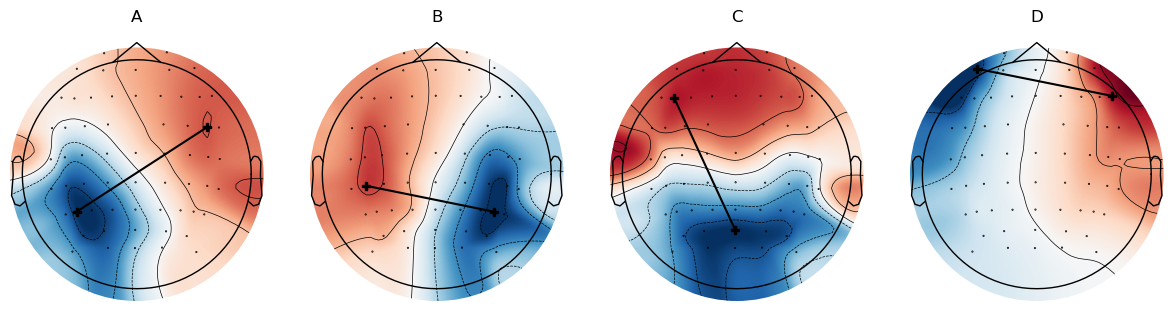

In [20]:
ModK.plot(show_gradient=True)
plt.show()

In [21]:
segmentation = ModK.predict(
    cleaned_eeg,
    reject_by_annotation=True,
    factor=10,
    half_window_size=10,
    min_segment_length=5,
    reject_edges=True,
)

In [13]:
len(cleaned_eeg.get_data()[0])

2555000

In [26]:
len(segmentation.labels)

2555000

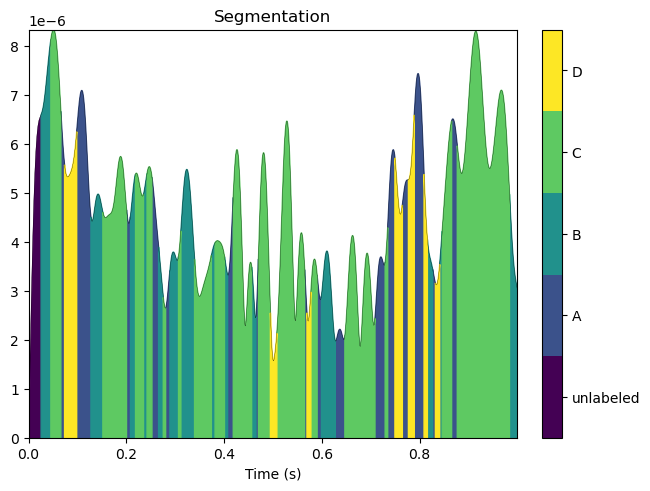

In [22]:
segmentation.plot(tmin=0, tmax=1)
plt.show()

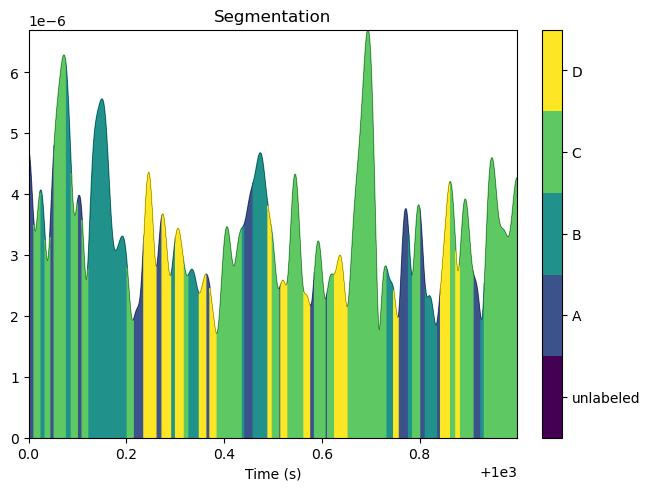

In [23]:
segmentation.plot(tmin=1000, tmax=1001)
plt.show()

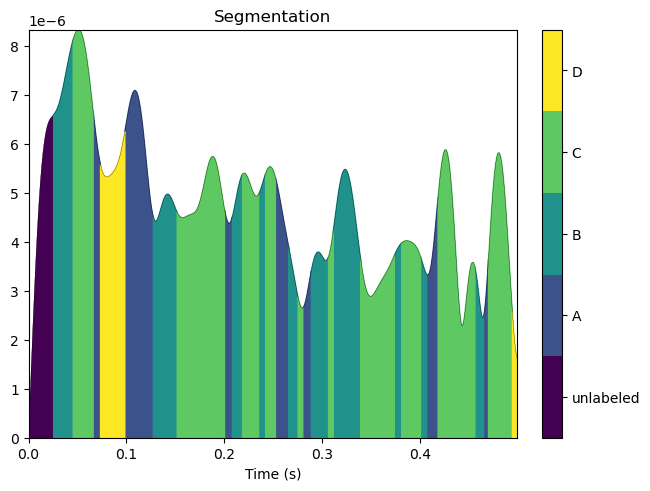

In [24]:
segmentation.plot(tmin=0, tmax=0.5)
plt.show()

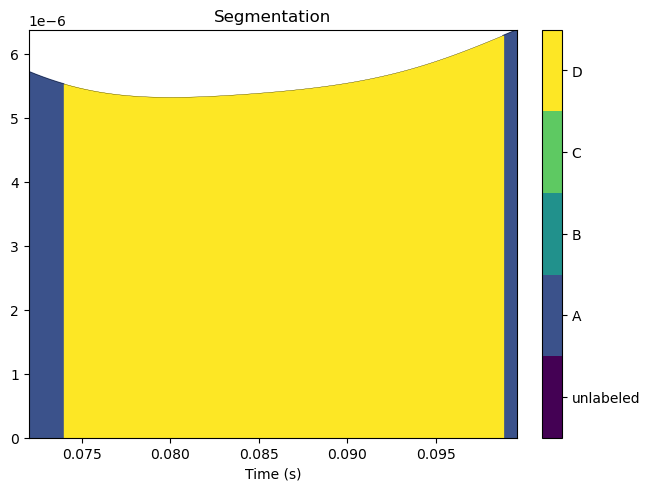

In [25]:
segmentation.plot(tmin=0.072, tmax=0.1)
plt.show()

## Microstates - Global Field Power Peaks

### By hand

#### Peaks

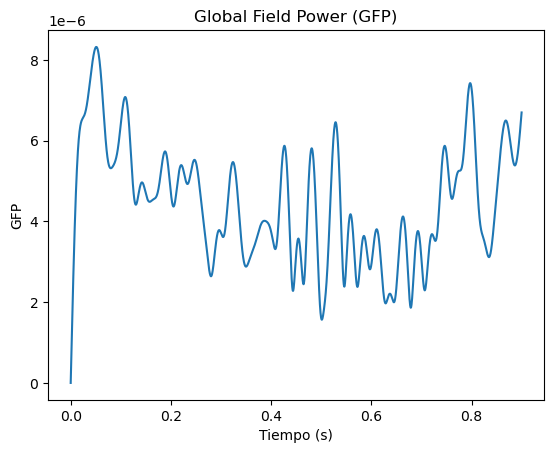

In [28]:
from scipy.signal import find_peaks
import numpy as np

# Extraer los datos EEG como un array numpy
data = cleaned_eeg.get_data()

# Calcular la GFP
gfp = np.std(data, axis=0)

# Identificar los picos del GFP (código existente)
peaks, _ = find_peaks(gfp)

# Definir el tamaño de la ventana alrededor de cada pico
window_size = 26  # por ejemplo

plt.plot(cleaned_eeg.times[:2250], gfp[:2250])
plt.xlabel('Tiempo (s)')
plt.ylabel('GFP')
plt.title('Global Field Power (GFP)')
plt.show()

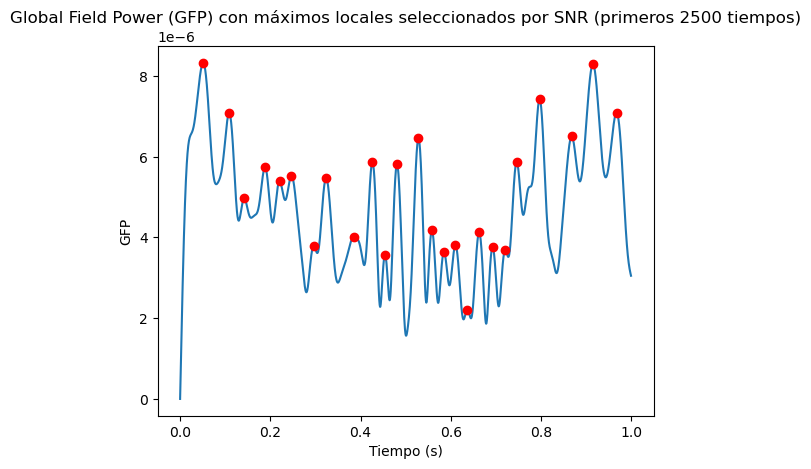

In [29]:
from scipy.signal import find_peaks
import numpy as np

# Limita los datos a los primeros 100 puntos de tiempo
gfp_short = gfp[:2500]

# Encuentra los máximos locales en la GFP limitada
peaks, _ = find_peaks(gfp_short)

# Calcula el SNR para cada máximo local
snr_values = []
for peak in peaks:
    window = 10  # Ancho de la ventana alrededor del pico
    peak_amplitude = gfp_short[peak]
    std_noise = np.std(gfp_short[max(0, peak-window):peak])  # Desviación estándar del ruido en una ventana anterior al pico
    snr = peak_amplitude / std_noise
    snr_values.append(snr)

# Selecciona los máximos locales con un SNR mayor que un umbral dado
umbral_snr = 2  # Puedes ajustar este umbral según tus necesidades
maximos_snr = [peak for peak, snr in zip(peaks, snr_values) if snr > umbral_snr]

# Visualiza los máximos locales seleccionados
import matplotlib.pyplot as plt

plt.plot(cleaned_eeg.times[:2500], gfp_short)
plt.plot(cleaned_eeg.times[maximos_snr][:2500], gfp_short[maximos_snr], 'ro')  # Resalta los máximos locales seleccionados en rojo
plt.xlabel('Tiempo (s)')
plt.ylabel('GFP')
plt.title('Global Field Power (GFP) con máximos locales seleccionados por SNR (primeros 2500 tiempos)')
plt.show()

#### Valleys

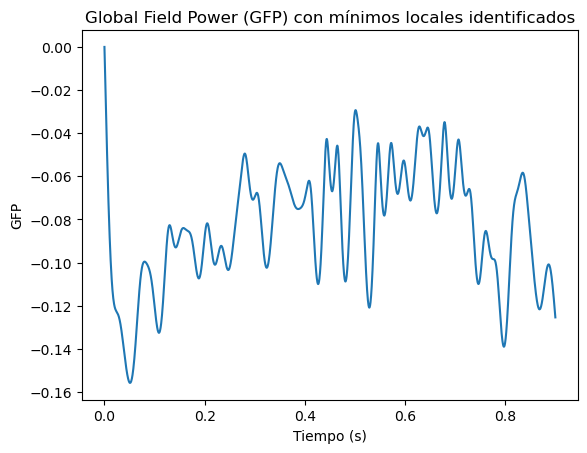

In [62]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que ya tienes definida la variable 'gfp' desde el primer código

# Invertir el signo de la señal GFP para encontrar mínimos en lugar de máximos
gfp_invertido = -gfp

# Identificar los mínimos locales de la señal invertida
valleys, _ = find_peaks(gfp_invertido, height=-np.inf)

# Visualizar los mínimos en el gráfico
plt.plot(cleaned_eeg.times[:2250], gfp_invertido[:2250])
#plt.plot(cleaned_eeg.times[valles][:2250], gfp[valles], 'go')  # Resaltar los mínimos en verde
plt.xlabel('Tiempo (s)')
plt.ylabel('GFP')
plt.title('Global Field Power (GFP) con mínimos locales identificados')
plt.show()

#### Comparisson between peaks and valleys

In [63]:
peaks

array([    128,     272,     355, ..., 2554777, 2554837, 2554909],
      dtype=int64)

In [64]:
valles

array([    200,     325,     394, ..., 2554755, 2554798, 2554863],
      dtype=int64)

In [65]:
len(peaks)

27686

In [66]:
len(valles)

27685

In [67]:
m = segmentation.labels[peaks]

In [68]:
len(m)

27686

In [118]:
import csv

lista_numeros = m
print("Lista original:", m)

valles = list(valles)
# Crear una lista para almacenar las sublistas con letra, índice de cambio y duración
data = []
microstates = []

# Variable para almacenar el índice de la última vez que cambió
ultimo_cambio = 0

# Variable para almacenar el evento
event = 1

# Recorrer la lista para detectar cambios y calcular duraciones
for i in range(1, len(lista_numeros)):
    
    if lista_numeros[i] != lista_numeros[i - 1]:
        # Cambiar los números según la especificación
        numero_cambiado = lista_numeros[i]
        if numero_cambiado == 0:
            letra_resultante = 'A'
        elif numero_cambiado == 1:
            letra_resultante = 'B'
        elif numero_cambiado == 2:
            letra_resultante = 'C'
        elif numero_cambiado == 3:
            letra_resultante = 'D'
        else:
            letra_resultante = 'E'

        microstates.append(letra_resultante)

       # Verificar en qué rango de eventos está el índice actual
        if event % 2 != 0:
            for j, (start_ce, end_ce) in enumerate(zip(start_samples_ce, end_samples_ce), start=1):
                if start_ce <= i <= end_ce:
                    event = j
                    break
        else:
            for j, (start_oe, end_oe) in enumerate(zip(start_samples_oe, end_samples_oe), start=1):
                if start_oe <= i <= end_oe:
                    event = j + len(start_samples_ce)  # Sumar la cantidad de rangos de EYES CLOSED

        # Agregar los datos a la lista
        if i == len(valles):
            data.append([letra_resultante, 0,  0, event])
        else:
            # Calcular la duración
            duracion = cleaned_eeg.times[valles[i]] - cleaned_eeg.times[ultimo_cambio]
            data.append([letra_resultante, valles[i], duracion, event])

            # Actualizar el índice del último cambio
            ultimo_cambio = valles[i]

# Encabezados
headers = ['microstate', 'index', 'event']

# Nombre del archivo CSV
file_name = 'datos.csv'

# Escribir datos en el archivo CSV
with open(file_name, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=';')
    #csv_writer.writerow(microstates)
    csv_writer.writerow(headers)  # Escribir encabezados
    csv_writer.writerows(data)

print("Archivo CSV creado exitosamente.")

Lista original: [ 2  0  1 ...  1  0 -1]


KeyboardInterrupt: 

In [119]:
ModK

Method,ModKMeans
Fit,100 initializations on 27686 samples
Cluster centers,4
GEV,62.84 %
Cluster centers names,"A, B, C, D"
Channels,61 EEG


In [120]:
cleaned_eeg.times[2492784]

997.1136

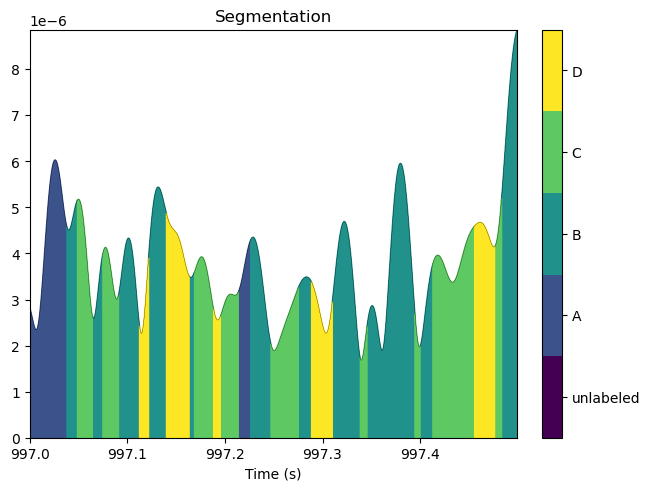

In [128]:
segmentation.plot(tmin=997, tmax=997.5)
plt.show()

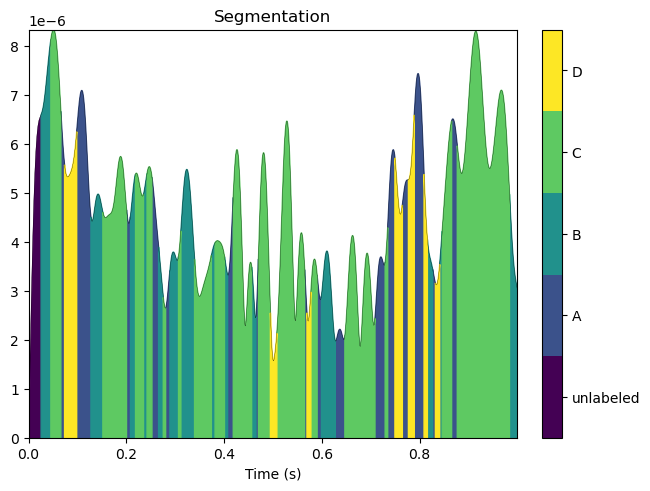

In [127]:
segmentation.plot(tmin=0, tmax=1)
plt.show()

#### Computation of microstates (by hand)

In [30]:
# Inicializa una lista para almacenar los microestados
microstates = []

# Para cada pico del GFP
for peak in peaks:
    # Define los límites de la ventana alrededor del pico
    start_idx = max(0, peak - window_size // 2)
    end_idx = min(len(cleaned_eeg.times) - 1, peak + window_size // 2)
    
    # Extrae las épocas de los datos EEG alrededor del pico
    epochs_data = data[:, start_idx:end_idx]

    # Promedia las épocas para obtener el microestado
    mean_epoch = np.mean(epochs_data, axis=1)
    microstates.append(mean_epoch)

# Convertir la lista de microestados a un array numpy
microstates = np.array(microstates)

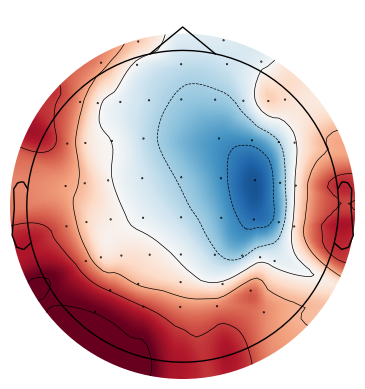

(<matplotlib.image.AxesImage at 0x1de3470d0d0>,
 <matplotlib.contour.QuadContourSet at 0x1de3470c250>)

In [32]:
from mne.viz import plot_topomap

# Selecciona el microestado que deseas visualizar (por ejemplo, el primero)
microstate_index = 20

# Extrae el microestado seleccionado
microstate = microstates[microstate_index]

# Plot del mapa topográfico del microestado
fig, ax = plt.subplots()
plot_topomap(microstate, cleaned_eeg.info, axes=ax, show=True)

In [33]:
group_cluster_centers = ChData(microstates.T, cleaned_eeg.info)

# Realizar el análisis de clustering
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(group_cluster_centers, n_jobs=2)

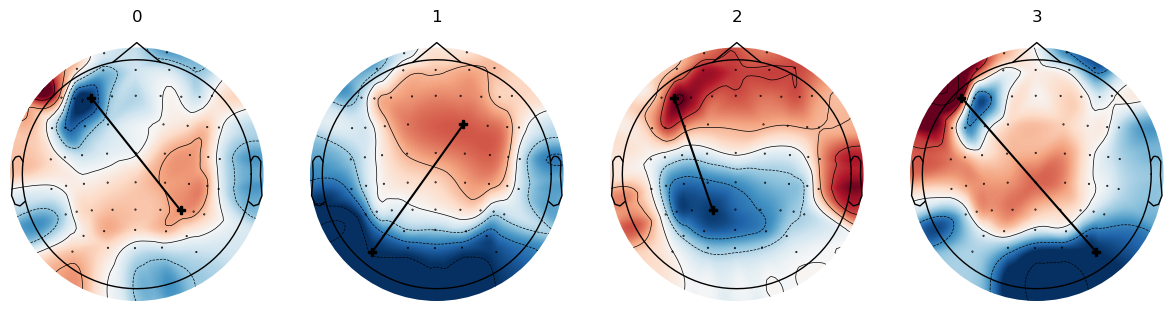

In [34]:
ModK.plot(show_gradient=True)
plt.show()

In [ ]:
segmentation_mano = ModK.predict(
    cleaned_eeg,
    reject_by_annotation=True,
    factor=10,
    half_window_size=10,
    min_segment_length=5,
    reject_edges=True,
)

In [ ]:
segmentation_mano.plot(tmin=0.045, tmax=0.120)
plt.show()

In [ ]:
from mne import EvokedArray
from mne.channels import find_layout
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt



# Inicializar una lista para almacenar los centros de los mapas topográficos en cada pico
topomap_centers = []

# Inicializar una lista para almacenar los mapas topográficos
topomaps = []

# Para cada pico del GFP
for peak in peaks[:4]:  # Limitado a los primeros 4 picos para el ejemplo, puedes ajustarlo según tus necesidades
    # Definir los límites de la ventana alrededor del pico
    start_idx = max(0, peak - window_size // 2)
    end_idx = min(len(cleaned_eeg.times) - 1, peak + window_size // 2)

    # Calcular los tiempos dentro de la ventana
    times = cleaned_eeg.times[start_idx:end_idx]

    # Calcular la topografía promedio en la ventana alrededor del pico
    epoch_data = cleaned_eeg.get_data()[:, start_idx:end_idx]
    mean_eeg = np.mean(epoch_data, axis=1)
    evoked = EvokedArray(mean_eeg[:, np.newaxis], cleaned_eeg.info)

    # Calcular el centro del mapa topográfico
    layout = find_layout(cleaned_eeg.info)
    pos = _auto_topomap_coords(evoked.info, picks=None, ignore_overlap=False, to_sphere=True, sphere=None)
    weights = evoked.data
    x_coords = pos[:, 0]
    y_coords = pos[:, 1]
    x_center = np.sum(weights * x_coords) / np.sum(weights)
    y_center = np.sum(weights * y_coords) / np.sum(weights)
    center = np.array([x_center, y_center])
    topomap_centers.append(center)

    # Agregar el centro al mapa topográfico
    evoked.plot_topomap(times=0, average=cleaned_eeg.times[peak], ch_type='eeg')
    plt.plot(center[0], center[1], 'go')  # Añadir punto verde en el centro
    #topomaps.append(plt.gcf())  # Agregar el mapa topográfico a la lista de figuras
    plt.close()



# Realizar el análisis de clustering
kmeans = KMeans(n_clusters=4)  # por ejemplo, 4 clusters
kmeans.fit(topomap_centers)
cluster_centers = kmeans.cluster_centers_

# Visualizar los resultados del clustering
print("Centros de los clusters:")
print(cluster_centers)


In [ ]:
from mne import EpochsArray

# Definir la duración deseada de cada época (en número de puntos de datos)
epoch_duration_points = int(epoch_duration * raw.info['sfreq'])

# Segmentar los datos EEG en épocas con la misma duración
epochs_data = []
for start, end in epochs_boundaries:
    # Obtener los índices correspondientes a los tiempos de inicio y fin de cada época
    start_idx = np.where(raw.times >= start)[0][0]
    end_idx = start_idx + epoch_duration_points  # Usar la duración deseada
    # Extraer los datos EEG para esta época y ajustar su tamaño si es necesario
    epoch_data = data[:, start_idx:end_idx]
    epochs_data.append(epoch_data)

# Crear un objeto EpochsArray con los datos de época
epochs = EpochsArray(epochs_data, cleaned_eeg.info)


In [ ]:
# Calcular la topografía promedio de cada época
average_topography = []
for epoch_data in epochs_data:
    if epoch_data.shape[0] != cleaned_eeg.info['nchan']:
        # Si la forma de epoch_data no es la esperada, intenta transponerla
        epoch_data = epoch_data.T  # Transponer epoch_data
    # Verificar si la forma es correcta ahora
    if epoch_data.shape[0] != cleaned_eeg.info['nchan']:
        print("Error: La forma de epoch_data no es la esperada.")
        continue  # Saltar esta época si hay un error
    # Calcular la media de la señal EEG en cada electrodo para esta época
    mean_eeg = np.mean(epoch_data, axis=1)
    # Crear un objeto RawArray con la topografía promedio de esta época
    average_topography.append(mne.io.RawArray([mean_eeg], cleaned_eeg.info))

# Visualizar las topografías promedio de algunas épocas
for i in range(5):  # Visualizar las primeras 5 épocas como ejemplo
    average_topography[i].plot_topomap(times=0, title=f'Época {i+1}')

